# Computer Vision MM 2025 - Practical 2 (v1.0)

## Instructions

1. Start Google Colab: https://colab.research.google.com. A modal dialog should have appeared to open a new notebook. If not, go to "File>Open notebook".
2. From the open notebook dialog, select the GitHub "tab" and enter this URL: https://github.com/chrirupp/cv_course
3. The notebook(s) should appear (*.ipynb). Select the one for the current practical.
4. To run a notebook on Colab you will typically need some data files (e.g., images). As Colab only loads the notebook itself, these other files need to be downloaded separately. The following cell is a `%%sh` block that downloads the required files. You can inspect the downloaded files by clicking on the "Files" tab on the left.

## Practicalities

The signing-off happens in the last half hour of each session or at the beginning of the following one.
As usual, when checking your work the demonstrator will want to see a working version of the program in action, as well as appropriate comments of your code. Try to make your report as concise as possible, perhaps in the form of appropriate comments to your code.

Since this is a new practical task, any errors, ambiguities or suggestions for improvement should be flagged as soon as possible.

If you are not familiar with the way practicals run, there are department-wide [rules](https://www.cs.ox.ac.uk/teaching/courses/2023-2024/practicals/). There you will find how the compulsory part, the optional tasks, and your report will factor into your mark.

## Advice

* You will need to look at the code for the lectures. There you will find many related computations that you can reuse and adapt to solve the practicals.
* The compulsory part of this practical is designed to give you additional understanding of the concepts taught in the lectures. It should be achievable in one session.

Here we import some libraries that we will need to process images, do maths, and to visualise results.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
%matplotlib inline

The usual set of helper functions:

In [2]:
%%sh
# Download the data - you need to do this only once
wget --no-verbose --output-document=image_dog.jpg https://github.com/chrirupp/cv_course/raw/main/data/image_dog.jpg

2025-11-12 11:19:13 URL:https://raw.githubusercontent.com/chrirupp/cv_course/main/data/image_dog.jpg [138693/138693] -> "image_dog.jpg" [1]


In [3]:
class Visualizer():
    def __init__(self, num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='', tight=False, cm=None):
        fig, self.axs = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
        # remove ticks
        if axis_off:
          plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        # set colormap
        if cm is not None:
            plt.set_cmap(cm)
        # set supertitle
        fig.suptitle(title)
        if tight:
            fig.subplots_adjust(top=0.88)

    def add_image_subplot(self, i, j, image, normalize=False, title_str=''):
        if normalize:
            image = self.normalize_image(image)
        if len(image.shape) == 3:
            #BGR -> RGB
            image = image[:, :, ::-1]
        self.axs[i, j].imshow(image)
        self.axs[i, j].set_title(title_str)

    def add_stem_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].stem(x, y)
        self.axs[i, j].set_title(title_str)

    def add_subplot(self, i, j, data, title_str=''):
        self.axs[i, j].plot(data)
        self.axs[i, j].set_title(title_str)

    def add_bar_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].bar(x, y)
        self.axs[i, j].set_title(title_str)

    @staticmethod
    def normalize_image(image):
        img = np.float64(image) - np.min(image)
        img /= np.max(img)
        return img

## Problem 2.1 - Image Classification

Let us train a linear classifier on the CIFAR10 dataset.
First, we will load the dataset and show some sample images. The convention in pytorch is to store images in a tensor of shape $C\times H \times W$, where $C=3$ is the number of channels and $H$ and $W$ are the height and width of the image. For training, we typically load mini-batches of size $N$, which adds another dimension $N \times C \times H \times W$ to our data. The image visualiser expects data in the format $H \times W \times C$ so you will find some shuffling of dimension in the code below. Additionally, OpenCV prefers processing images in BGR format, while pytorch uses RGB so we also need to reverse the order of the $C$ dimension.

100%|██████████| 170M/170M [00:02<00:00, 77.5MB/s]


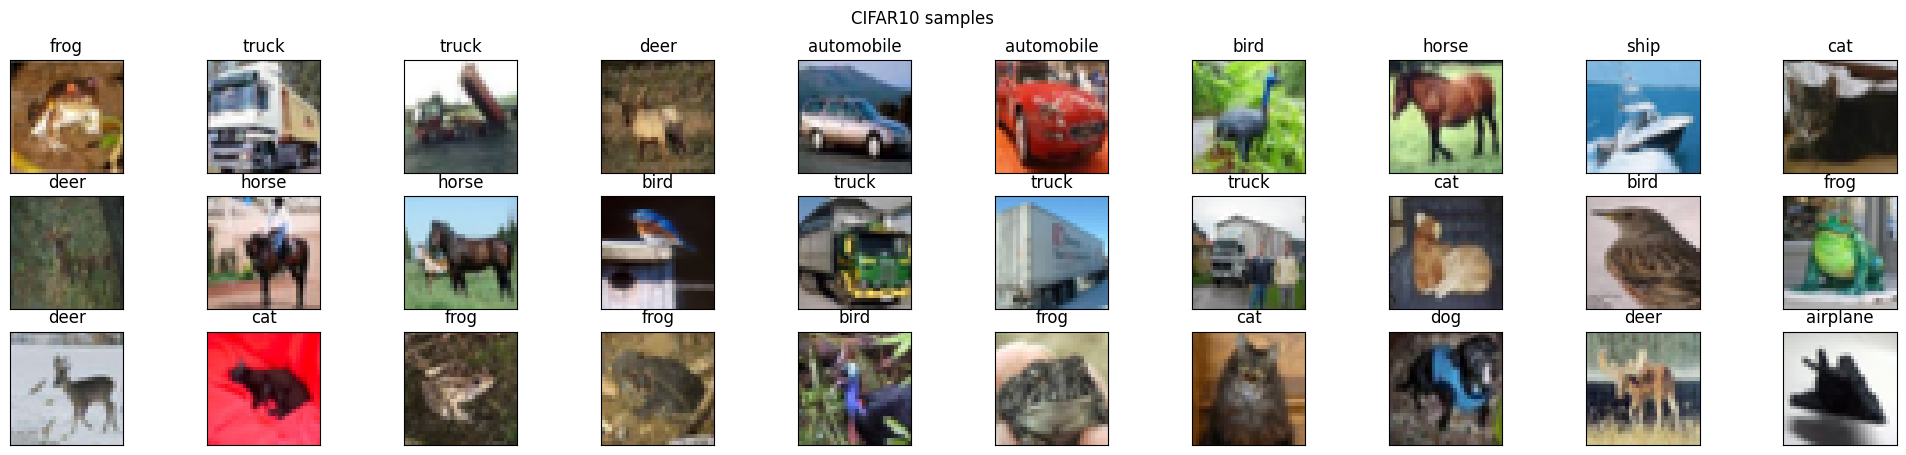

In [4]:
# get cifar10 dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('../data', train=False, download=True, transform=transform)


# samples from cifar10 dataset
vis = Visualizer(3, 10, figsize=(25,5), title='CIFAR10 samples')
for i in range(30):
    image = train_dataset[i][0].permute(1, 2, 0).numpy()[:,:,::-1]
    vis.add_image_subplot(i // 10, i % 10, image, title_str=train_dataset.classes[train_dataset[i][1]])


While we can "train" a linear classifier by solving a linear system analytically, we will now do it with gradient descent to familiarise ourselves with the concepts of training. Training typically happens in epochs, where one epoch is a full loop over the training set. Familiarise yourself with the training code below. Answer the following questions:

* What is the purpose of `optimizer.zero_grad()`?
* What is `citerion`?
* How do we determine which class the model predicts?
* How many parameters does our model have?
* What accuracy would we expect for a model that is randomly initialised?


In [5]:
# create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # pick class with highest output value
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        for data, target in tqdm(train_loader):
            # sets gradients to None
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        test_acc = evaluate(model, test_loader)
        test_accuracies.append(test_acc)
        print(f'Epoch {epoch+1}/{num_epochs}, Test accuracy: {test_acc:.2f}%')

    return train_losses, test_accuracies

class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # model has 3 * 32 * 32 * 10 + 10(biases) params
        self.fc = torch.nn.Linear(3*32*32, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc(x)
        return x

model = LinearModel()
# states the loss function to be used, in this case CrossEntropy Loss
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model currently randomly initialized should have 10% accuracy
train_losses, test_accuracies = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)


100%|██████████| 391/391 [00:09<00:00, 42.52it/s]


Epoch 1/5, Test accuracy: 32.73%


100%|██████████| 391/391 [00:09<00:00, 43.20it/s]


Epoch 2/5, Test accuracy: 37.89%


100%|██████████| 391/391 [00:09<00:00, 42.82it/s]


Epoch 3/5, Test accuracy: 38.14%


100%|██████████| 391/391 [00:08<00:00, 43.51it/s]


Epoch 4/5, Test accuracy: 37.78%


100%|██████████| 391/391 [00:09<00:00, 43.40it/s]


Epoch 5/5, Test accuracy: 37.50%


Now that the model is trained, visualise the weights of the linear layer. There are $3\cdot 32 \cdot 32$ weights for each class which you can visualise simply as an image. What do you see? Why does it look like that?

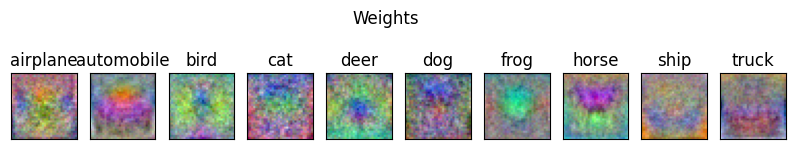

In [25]:
vis = Visualizer(1, 10, figsize=(10,2), title='Weights')
for i in range(10):
    weights = model.fc.weight.detach().numpy()[i].reshape((3, 32, 32)).transpose((1, 2, 0))
    vis.add_image_subplot(0, i, weights, title_str=train_dataset.classes[i], normalize=True)

We will now train a small CNN. It consists of
* Convolution: size 3x3, number of channels 3 (RGB), number of filters: 16, padding: 1 on all sides
* ReLU
* MaxPooling: size 2x2, stride: 2
* Fully Connected layer: 4096 x 10

In [26]:
class MiniCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # numbers outputs is 16 * (32 * 32)
        # max pooling outputs (16 * 32 * 32) / 4 outputs
        # thus FC layer has 4 * 32 * 32 = 4096 inputs each input has 10 weights associated with it one for each class
        self.fc = torch.nn.Linear(4096, 10)

    def forward(self, x):
        # relu and max pooling do not have trainable parameters associated with them so they do not need to be defined in the constructor
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 4096)
        x = self.fc(x)
        return x

model = MiniCNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, test_accuracies = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)

100%|██████████| 391/391 [00:23<00:00, 16.83it/s]


Epoch 1/5, Test accuracy: 49.13%


100%|██████████| 391/391 [00:22<00:00, 17.27it/s]


Epoch 2/5, Test accuracy: 51.39%


100%|██████████| 391/391 [00:23<00:00, 16.87it/s]


Epoch 3/5, Test accuracy: 54.21%


100%|██████████| 391/391 [00:23<00:00, 16.99it/s]


Epoch 4/5, Test accuracy: 54.72%


100%|██████████| 391/391 [00:23<00:00, 16.97it/s]


Epoch 5/5, Test accuracy: 56.21%


This model should achieve around 57% accuracy on the test set (with the default settings for batch size, learning rate, and number of epochs).

Answer the following questions:
* Why do we need to define the convolution and FC layer in the constructor (`__init__()`) of the model, but ReLU and max_pool are simply used in the forward pass?
* How do we know that the fully connected layer needs to be of size 4096 x 10?

Then, expand the model with a second set of convolution (3x3, 32 filters, padding 1), ReLU, max_pool (2x2, stride 2). You will need to also adjust the size of the FC layer accordingly. Confirm that this improves the accuracy.

In [27]:
class MiniCNN2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # has outputs of shape 16 * 16 * 16 after max pooling
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # has outputs shape 32 * 8 * 8 after max pooling
        self.fc = torch.nn.Linear(2048, 10)

    def forward(self, x):
        # relu and max pooling do not have trainable parameters associated with them so they do not need to be defined in the constructor
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 2048)
        x = self.fc(x)
        return x

model = MiniCNN2()
# states the loss function to be used, in this case CrossEntropy Loss
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model currently randomly initialized should have 10% accuracy
train_losses, test_accuracies = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)

100%|██████████| 391/391 [00:36<00:00, 10.82it/s]


Epoch 1/5, Test accuracy: 48.98%


100%|██████████| 391/391 [00:36<00:00, 10.69it/s]


Epoch 2/5, Test accuracy: 54.69%


100%|██████████| 391/391 [00:36<00:00, 10.61it/s]


Epoch 3/5, Test accuracy: 58.00%


100%|██████████| 391/391 [00:37<00:00, 10.53it/s]


Epoch 4/5, Test accuracy: 59.44%


100%|██████████| 391/391 [00:35<00:00, 10.88it/s]


Epoch 5/5, Test accuracy: 61.00%


### Optional Task - Be a hero
You have now several options that might improve the performance:
* Change the architecture further.
* Train longer.
* Change other hyper parameters: batch size, learning rate, kernel sizes, number of filters, activation functions, etc.
* Data augmentations such as left-right flipping (see `transform` in the beginning).

Try to find a combination that gets better accuracy than `MiniCNN2` (at least 63%). Do not change the test set! (State-of-the-art models get around 95% ;) )
Hint: if you are considering to tinker with this for a while: switch to hardware acceleration (GPU) - Edit->Notebook settings. Then change the code to move the model and tensors to the GPU `.to("cuda")` before starting to train. You will need to move each batch to the device too. Move predictions back to the CPU `.cpu()` so that they do not accumulate memory.

## Problem 2.2 - Occlusion Method

The code for the lecture implements the occlusion method for CNNs, by blocking out (i.e. setting to 0) parts of the image and measuring the change in response for the target class for every location, and converting it into a heatmap.
We will now do the same for a transformer architecture. However, since the transformer already divides the image into patches, we can directly block out tokens instead of modifying the image.

In [ ]:
model = torch.hub.load('pytorch/vision', 'vit_b_16', weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1)
class_names = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1.meta["categories"]

# load image
image = cv2.imread('image_dog.jpg')

# preprocess image
image = image[:, :image.shape[0]]
image = cv2.resize(image, (224, 224))
vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='Input image')
vis.add_image_subplot(0, 0, image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image - np.array([0.485, 0.456, 0.406])
image = image / np.array([0.229, 0.224, 0.225])
image = image.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)
image = torch.from_numpy(image).float()

Models trained on the ImageNet dataset are trained using normalised images (subtract mean, divide by variance) this is reflected in the image pre-processing code above.

Below you are given a function `predict`.

Explain:
* the role of `batch_class_token`
* `encoder.pos_embedding`
* the reason for `x[:, 0]`


In [ ]:
def predict(model, image):
    x = model._process_input(image)
    n = x.shape[0]
    batch_class_token = model.class_token.expand(n, -1, -1)
    x = torch.cat([batch_class_token, x], dim=1)

    input = x + model.encoder.pos_embedding
    input = model.encoder.layers(input)
    x = model.encoder.ln(input)
    x = x[:, 0]
    return model.heads(x).detach().cpu().numpy()

# predict
output = predict(model, image)
pred = class_names[output.argmax()]
print(f'Predicted class: {pred}')

Implement the occlusion method by individually "occluding" image token from the input to the encoder and measuring the change in the target class. Be careful: the class-token is the first token in the input sequence. Visualise the heatmap.

In [ ]:
def predict_drop_token(model, image, token):
    # TODO: implement the function
    return None

# get prediction
with torch.no_grad():
    original_prediction = 0 # TODO: get the original prediction

top_class = original_prediction.argmax()
print(f'Class: {class_names[top_class]}')

heatmap = np.zeros((?, ?))
for i in tqdm(range(heatmap.size)):
    response = predict_drop_token(model, image, i)
    heatmap[?, ?] = 0  # TODO: calculate the heatmap

# plot heatmap
vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='Heatmap')
vis.add_image_subplot(0, 0, heatmap)


## Optional Task - Visualise Everything
Upload some images and show predictions and heatmaps. Are their clear failure modes? What happens if you visualise a class that is not in the image?

## Problem 2.3 - Adversarial Examples

Adversarial examples are inputs to the network that look like normal images to humans, but cause the network to predict completely wrong classes with very high confidence. The are called _adversarial_ since they are specifically constructed to fool the model while being imperceptible to humans.

A straightforward way to construct adversarial examples is a process very similar to the Input Reconstruction visualisation technique. However, instead of starting the optimisation from random noise, we start from the image that we want to modify. We then make small gradient steps in the image that maximise our target adversarial class. Here, we do not need any regularisers since we are looking for a solution very close to the original image.

Take the input reconstruction code from the lecture notebook on visualisation as an example on how to setup gradient descent on pixels, given a network and target class.
* You will not need any regularisation techniques.
* you also do not need to normalise the gradient.
* start from image_dog instead of random noise.
* choose a target class (e.g. 637 "mailbox")
* optimise and show your adversarial example.
* pass your adversarial example through the model and show that it predicts the target class.

Hint: you will need to normalise the image (like in the code above). When visualising the result, you need to invert this process.

In [ ]:
# load image
image = cv2.imread('image_dog.jpg')

# preprocess image
image = image[:, :image.shape[0]]
image = cv2.resize(image, (224, 224))
vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='Input image')
vis.add_image_subplot(0, 0, image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image - np.array([0.485, 0.456, 0.406])
image = image / np.array([0.229, 0.224, 0.225])
image = image.transpose(2, 0, 1)
image = np.expand_dims(image, axis=0)
image = torch.from_numpy(image).float()

def de_normalise_image(x):
    # TODO: denormalise image (test it by using it on the normalised image and plot it)
    return x

model = torch.hub.load('pytorch/vision', 'resnet50', weights=torchvision.models.resnet.ResNet50_Weights.DEFAULT)
class_names = torchvision.models.resnet.ResNet18_Weights.DEFAULT.meta["categories"]

# pass image through model
output = model(image)
pred = output.argmax()
print(f'Predicted class: {class_names[pred]}')

top_class = 637 # This is the class for 'mailbox'
num_iterations = 50
input = 0  # TODO: initialise with image
input = torch.nn.Parameter(input, requires_grad=True)
optimizer = torch.optim.Adam([input], lr=0.1)

for i in tqdm(range(num_iterations)):
    prediction = model(input)
    loss = 0  # TODO: find a loss function that maximises the class score
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

vis = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title=f'Input maximisation class {class_names[top_class]}')
vis.add_image_subplot(0, 0, de_normalise_image(image))

# pass image through model
output = model(input)
# get class index
pred = output.argmax()
print(f'Predicted class of adversarial example: {class_names[pred]}')

Visualise the difference image between the original and the adversarial example.
* Do the same for different classes.
* Modify the code so that the loop ends as soon as the target class is higher than all others. Are some classes "easier" than others?

## Optional Tasks
* Save and load an adversarial example to and from a jpg file. Does it still work? Why? How could you make it more robust?
* Universal perturbations: another curious finding is that there are universal perturbations. A UP is a noise pattern $\epsilon$ that, if added to _any_ image, causes a misclassification as the target class. Try to find a universal perturbation for one of your CIFAR10 CNNs from the first problem of this sheet. You can do this by running the learning of the perturbation over batches of the training set. For each image in the batch, you will need to add your universal perturbation. The only thing that is learned in this training loop is the pattern (the model stays fixed). Learn your universal perturbation on the training set and show some examples on the test set. How do they compare to adversarial examples?
